# Fitting a SIR model to data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
import lmfit
import corner
import emcee

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

emcee     : 3.1.2
matplotlib: 3.5.2
pandas    : 1.4.3
corner    : 2.2.1
numpy     : 1.23.0
lmfit     : 1.0.3



In [3]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")[["location", "date", "new_cases", "total_deaths"]]
df = df[df["location"] == "United States"]
df["total_cases"] = df.new_cases.rolling(10).sum()

In [4]:
df = df.drop("location", axis=1)
df = df.sort_values(by="date")

In [5]:
df = df[(df.date >= "2020-11-01") & (df.date <= "2021-02-15")]

In [6]:
Y = df[["total_cases", "total_deaths"]].dropna().to_numpy()
X = np.array(list(range(0, len(Y))), dtype=float)

In [7]:
def SEIRD_model(t, y, beta, gamma, sigma, CFR):
    S, E, I, R, D = y
    dSdt = - beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = (1 - CFR) * gamma * I
    dDdt = CFR * gamma * I

    return dSdt, dEdt, dIdt, dRdt, dDdt

In [8]:
# Initial conditions

N = 380e6
E0 = 2 * Y[0, 0]
I0 = Y[0, 0]
R0 = 0
D0 = Y[0, 1]
S0 = N - E0 - I0 - D0
starting_values = (S0, E0, I0, R0, D0)

In [9]:
theta = lmfit.Parameters()
theta.add("beta", value=0.5, min=0, max=5)
theta.add("gamma", value=1/10, min=0, max=1)
theta.add("sigma", value=1/3, min=0, max=1)
theta.add("CFR", value=0.05, min=0, max=1)

In [10]:
def residual(theta, X, Y, starting_values=starting_values):
    parvals = theta.valuesdict()
    beta, gamma, sigma, CFR = parvals["beta"], parvals["gamma"], parvals["sigma"], parvals["CFR"]
    res = solve_ivp(fun=SEIRD_model,
                    t_eval=X,
                    t_span=(X[0], X[-1]),
                    y0=starting_values,
                    args=(beta, gamma, sigma, CFR))

    return (res.y[[2, 4], :] - Y.T).ravel()

In [11]:
fit = lmfit.minimize(residual, theta, method="nelder", args=(X, Y, starting_values))

In [12]:
lmfit.printfuncs.report_fit(fit)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1039
    # data points      = 214
    # variables        = 4
    chi-square         = 2.8046e+12
    reduced chi-square = 1.3355e+10
    Akaike info crit   = 4993.40705
    Bayesian info crit = 5006.87095
[[Variables]]
    beta:   0.56658699 +/- 0.00129481 (0.23%) (init = 0.5)
    gamma:  0.48938568 +/- 9.5015e-04 (0.19%) (init = 0.1)
    sigma:  0.31893395 +/- 8.6813e-04 (0.27%) (init = 0.3333333)
    CFR:    0.00256718 +/- 8.9322e-05 (3.48%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = 0.914


In [13]:
res = lmfit.minimize(lambda x: residual(x, X, Y, starting_values),
                     method="emcee",
                     burn=1_000,
                     steps=25_000,
                     thin=10,
                     params=theta,
                     is_weighted=False,
                     progress=True)

100%|██████████| 25000/25000 [3:23:22<00:00,  2.05it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 500;
tau: [439.03952461 394.24408661 261.33310332 668.39723869 309.46723316]


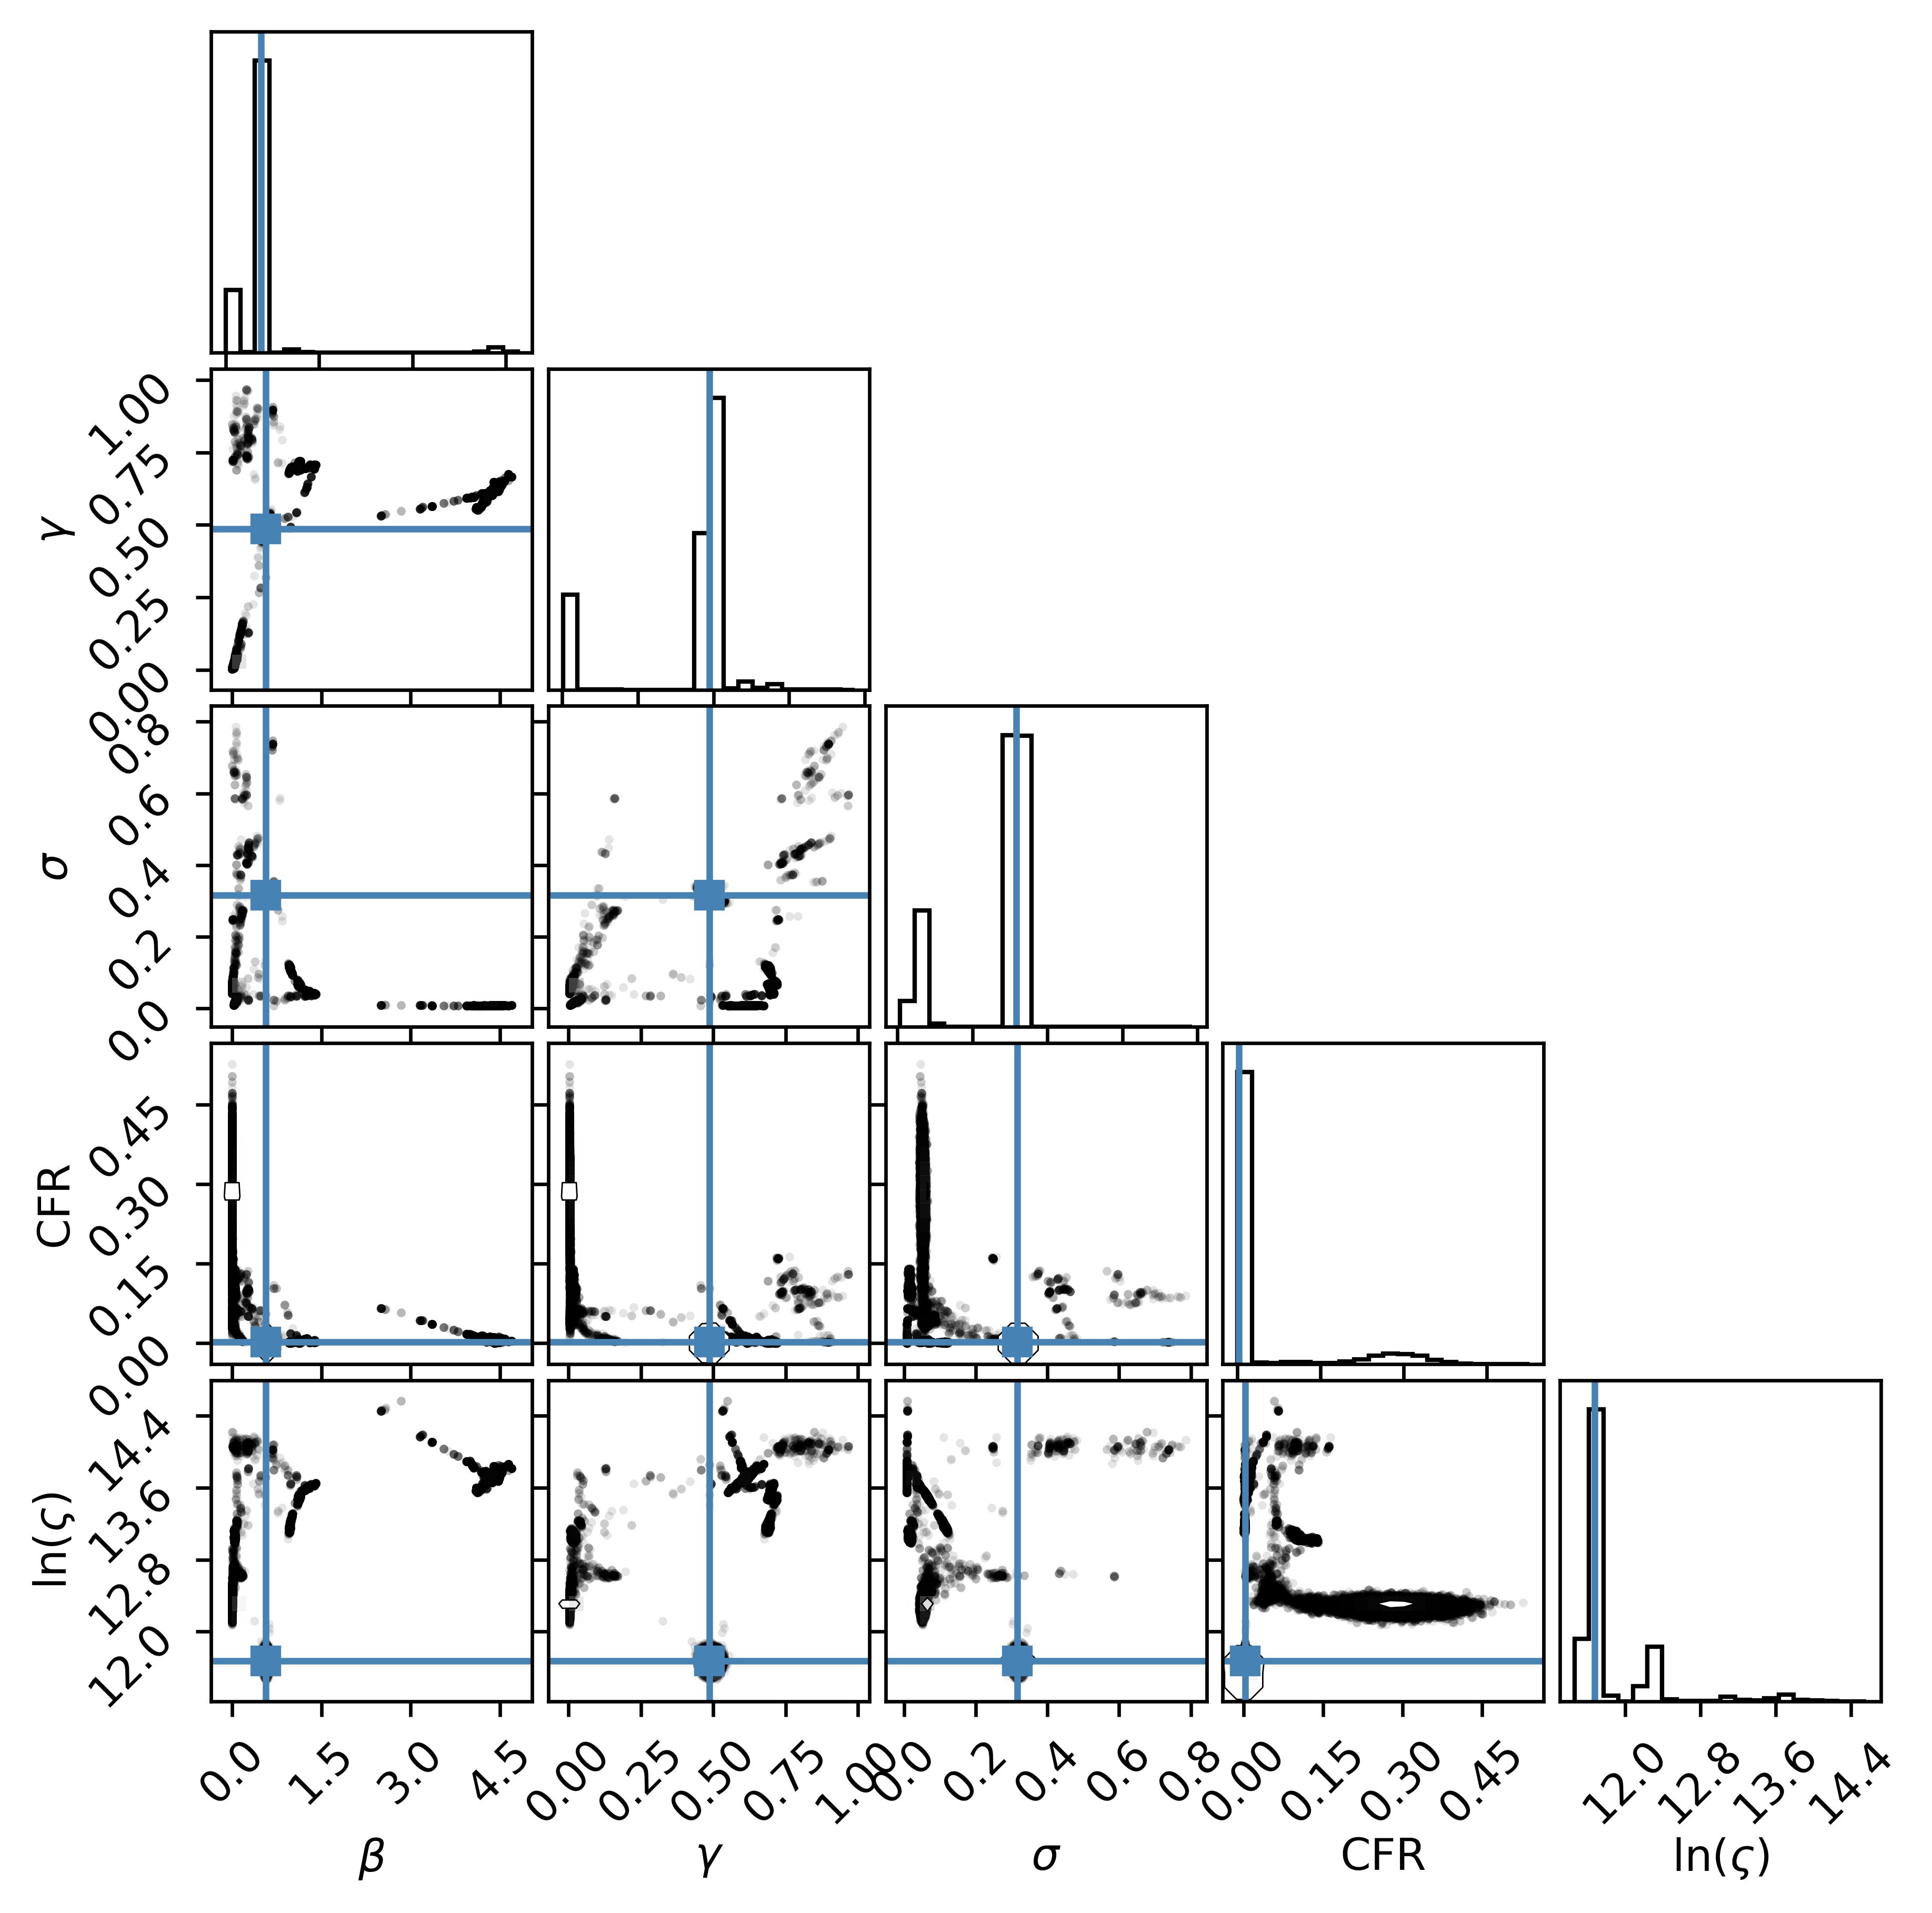

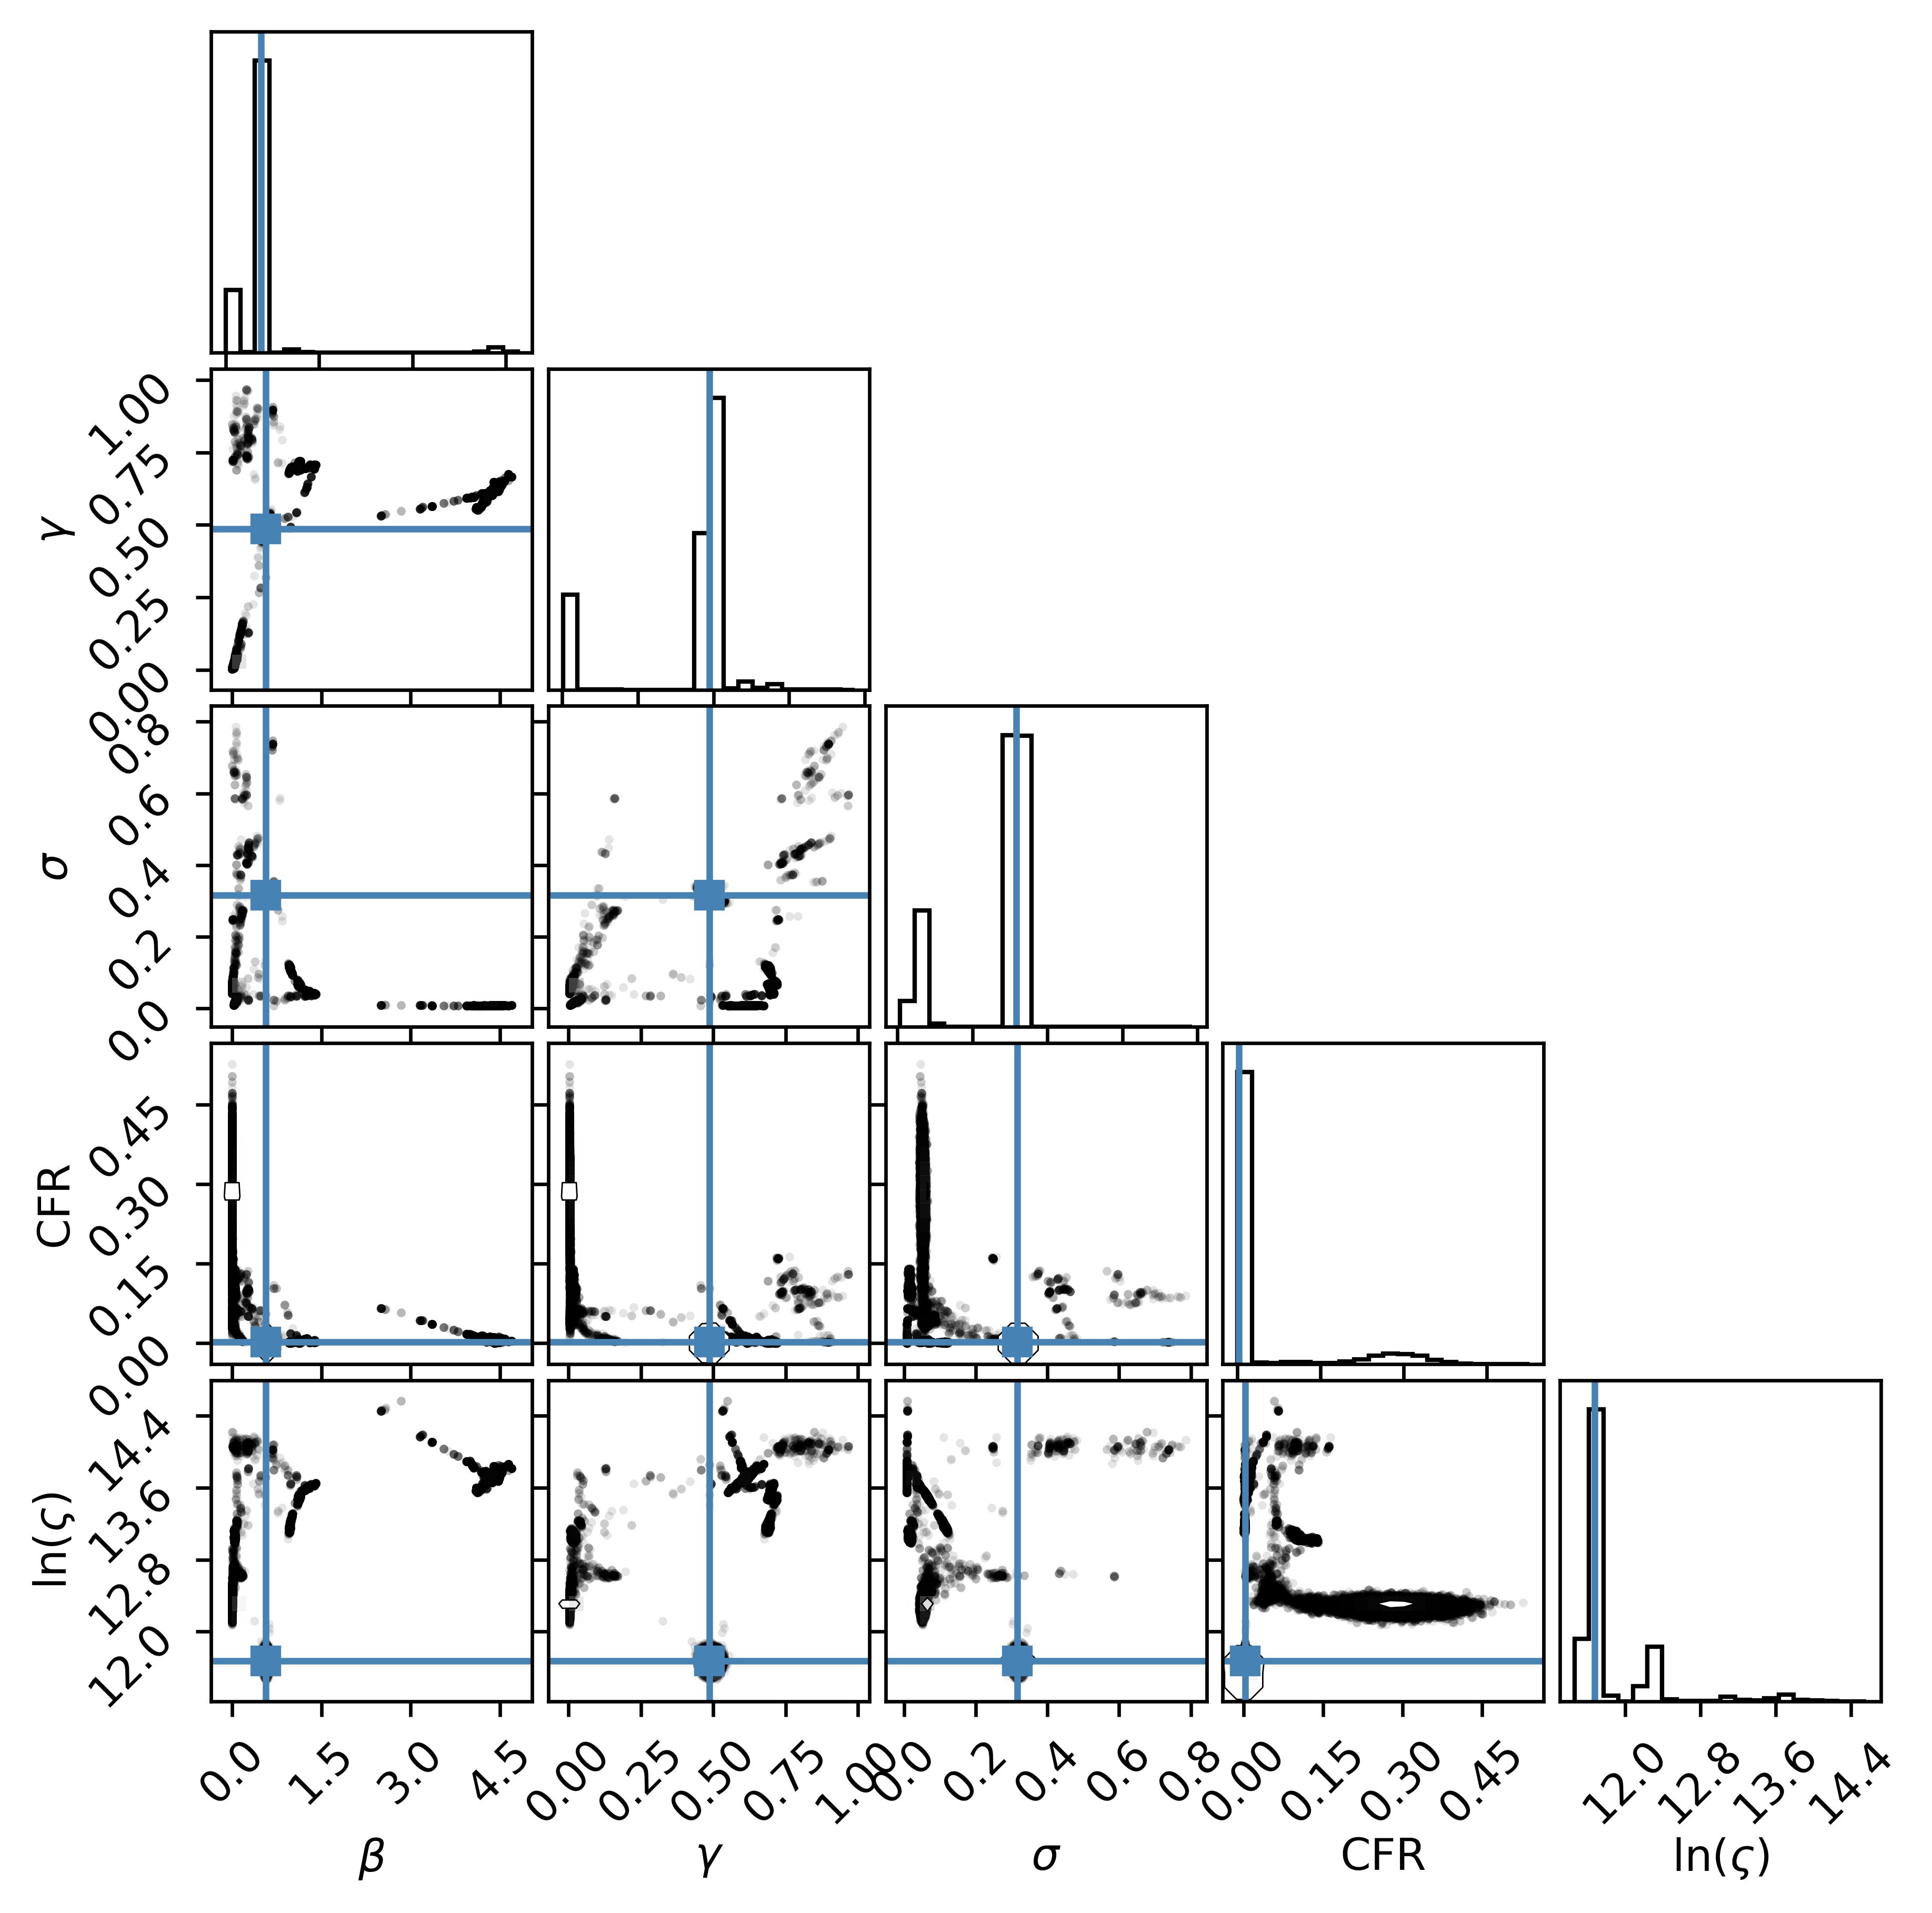

In [14]:
fig = plt.figure(figsize=(6, 6), dpi=600)
corner.corner(res.flatchain,
              labels=["$\\beta$", "$\\gamma$", "$\\sigma$", "CFR", "$\\ln(\\varsigma)$"],
              truths=list(res.params.valuesdict().values()),
              fig=fig,
              labelpad=0.12,
              hist2d_kwargs={"no_fill_contours": True,
                             "plot_density": True},
              contour_kwargs={"linewidths": 0.33})